In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import Callback
from google.colab import files
from itertools import cycle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Функция для загрузки данных
def load_data(data_folder):
    csv_file = os.path.join(data_folder, '_classes.csv')
    df = pd.read_csv(csv_file)
    return df

In [4]:
# Настройка путей к данным
base_data_dir = '/content/drive/My Drive/Bite_detection/dataset'
train_data_dir_teeth = os.path.join(base_data_dir, 'teeth/train')
validation_data_dir_teeth = os.path.join(base_data_dir, 'teeth/valid')
test_data_dir_teeth = os.path.join(base_data_dir, 'teeth/test')

train_data_dir_face_front = os.path.join(base_data_dir, 'full_face/train')
validation_data_dir_face_front = os.path.join(base_data_dir, 'full_face/valid')
test_data_dir_face_front = os.path.join(base_data_dir, 'full_face/test')

train_data_dir_face_profile = os.path.join(base_data_dir, 'profile_face/train')
validation_data_dir_face_profile = os.path.join(base_data_dir, 'profile_face/valid')
test_data_dir_face_profile = os.path.join(base_data_dir, 'profile_face/test')

In [5]:
# Загрузка данных из CSV
train_df_teeth = load_data(train_data_dir_teeth)
val_df_teeth = load_data(validation_data_dir_teeth)
test_df_teeth = load_data(test_data_dir_teeth)

train_df_face_front = load_data(train_data_dir_face_front)
val_df_face_front = load_data(validation_data_dir_face_front)
test_df_face_front = load_data(test_data_dir_face_front)

train_df_face_profile = load_data(train_data_dir_face_profile)
val_df_face_profile = load_data(validation_data_dir_face_profile)
test_df_face_profile = load_data(test_data_dir_face_profile)

In [6]:
# Параметры
img_width, img_height = 128, 128
batch_size = 8
num_classes_teeth = 6  # Количество классов для зубов: нормальные, мезиальные, дистальные, открытые, перекрестные, глубокие


In [7]:
# Генератор данных
def data_generator(data_frame, data_dir, batch_size, img_height, img_width, datagen):
    while True:
        indices = np.arange(len(data_frame))
        np.random.shuffle(indices)
        for start in range(0, len(indices), batch_size):
            end = min(start + batch_size, len(indices))
            batch_indices = indices[start:end]
            batch_df = data_frame.iloc[batch_indices]

            X = []
            y = []
            for idx, row in batch_df.iterrows():
                img_path = os.path.join(data_dir, row['filename'])
                image = load_img(img_path, target_size=(img_height, img_width))
                image = img_to_array(image)
                label = row[1:].values.astype(int)  # Первая колонка 'filename', остальные - метки классов

                X.append(image)
                y.append(label)

            X = np.array(X)
            y = np.array(y)

            augmented_X, augmented_y = [], []
            for i in range(len(X)):
                augmented = next(datagen.flow(np.expand_dims(X[i], axis=0), np.expand_dims(y[i], axis=0), batch_size=1))
                augmented_X.append(augmented[0][0])
                augmented_y.append(augmented[1][0])

            yield np.array(augmented_X), np.array(augmented_y)

In [8]:
# Функция для создания батчей одинакового размера
def batch_generator(generator, batch_size):
    while True:
        batch = next(generator)
        if len(batch[0]) != batch_size:
            continue
        yield batch

In [9]:
# Настройка ImageDataGenerator для минимальной аугментации данных
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
    )

val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Генераторы для тренировочных данных
train_generator_teeth = batch_generator(data_generator(train_df_teeth, train_data_dir_teeth, batch_size, img_height, img_width, train_datagen), batch_size)
train_generator_face_front = batch_generator(data_generator(train_df_face_front, train_data_dir_face_front, batch_size, img_height, img_width, train_datagen), batch_size)
train_generator_face_profile = batch_generator(data_generator(train_df_face_profile, train_data_dir_face_profile, batch_size, img_height, img_width, train_datagen), batch_size)

# Генераторы для валидационных данных
val_generator_teeth = batch_generator(data_generator(val_df_teeth, validation_data_dir_teeth, batch_size, img_height, img_width, val_datagen), batch_size)
val_generator_face_front = batch_generator(data_generator(val_df_face_front, validation_data_dir_face_front, batch_size, img_height, img_width, val_datagen), batch_size)
val_generator_face_profile = batch_generator(data_generator(val_df_face_profile, validation_data_dir_face_profile, batch_size, img_height, img_width, val_datagen), batch_size)

# Генераторы для тестовых данных
test_generator_teeth = batch_generator(data_generator(test_df_teeth, test_data_dir_teeth, batch_size, img_height, img_width, val_datagen), batch_size)
test_generator_face_front = batch_generator(data_generator(test_df_face_front, test_data_dir_face_front, batch_size, img_height, img_width, val_datagen), batch_size)
test_generator_face_profile = batch_generator(data_generator(test_df_face_profile, test_data_dir_face_profile, batch_size, img_height, img_width, val_datagen), batch_size)


In [11]:
# Функция для создания уникальных имен слоев
def clone_model_with_new_names(model, suffix):
    config = model.get_config()
    for layer in config['layers']:
        layer['config']['name'] = layer['config']['name'] + suffix
    new_model = Model.from_config(config)
    new_model.set_weights(model.get_weights())
    return new_model


In [12]:
# Использование предобученной модели VGG16 для каждого типа изображения
def create_base_model(input_shape, suffix):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model = clone_model_with_new_names(base_model, suffix)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = Flatten()(x)
    return base_model.input, x

In [13]:
# Вход для изображений зубов
input_teeth, x1 = create_base_model((img_width, img_height, 3), '_teeth')

# Вход для изображений лица анфас
input_face_front, x2 = create_base_model((img_width, img_height, 3), '_face_front')

# Вход для изображений лица профиль
input_face_profile, x3 = create_base_model((img_width, img_height, 3), '_face_profile')

# Объединение выходов трех потоков
merged = concatenate([x1, x2, x3])

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
# Полносвязные слои
x = Dense(256, activation='relu')(merged)
x = Dropout(0.5)(x)
output = Dense(num_classes_teeth, activation='softmax')(x)

In [15]:
# Определение модели
merged_model = Model(inputs=[input_teeth, input_face_front, input_face_profile], outputs=output)

# Компиляция модели
merged_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
# Создание генератора для объединенных данных
def generator_multiple(generator1, generator2, generator3):
    while True:
        g1 = next(generator1)
        g2 = next(generator2)
        g3 = next(generator3)
        yield [g1[0], g2[0], g3[0]], g1[1]

In [17]:
# Генераторы для объединенных данных
train_generator = generator_multiple(cycle(train_generator_teeth), cycle(train_generator_face_front), cycle(train_generator_face_profile))
val_generator = generator_multiple(cycle(val_generator_teeth), cycle(val_generator_face_front), cycle(val_generator_face_profile))
test_generator = generator_multiple(cycle(test_generator_teeth), cycle(test_generator_face_front), cycle(test_generator_face_profile))


In [18]:
# Настройка обратного вызова для вычисления Test accuracy после каждой эпохи
class TestAccuracyCallback(Callback):
    def __init__(self, test_generator, test_steps):
        super().__init__()
        self.test_generator = test_generator
        self.test_steps = test_steps
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        loss, accuracy = self.model.evaluate(self.test_generator, steps=self.test_steps, verbose=0)
        self.test_accuracies.append(accuracy)
        print(f'Test accuracy after epoch {epoch+1}: {accuracy:.4f}')


In [19]:
test_steps = min(len(test_df_teeth), len(test_df_face_front), len(test_df_face_profile)) // batch_size
print('batch_size: ', batch_size)
print('len(test_df_teeth): ', len(test_df_teeth))
print('len(test_df_face_front): ', len(test_df_face_front))
print('len(test_df_face_profile): ', len(test_df_face_profile))
test_accuracy_callback = TestAccuracyCallback(test_generator, test_steps)

print('test_steps: ', test_steps)

# Обучение модели
steps_per_epoch = min(len(train_df_teeth), len(train_df_face_front), len(train_df_face_profile)) // batch_size
validation_steps = min(len(val_df_teeth), len(val_df_face_front), len(val_df_face_profile)) // batch_size

print('steps_per_epoch: ',steps_per_epoch)
print('validation_steps: ', validation_steps)

batch_size:  8
len(test_df_teeth):  56
len(test_df_face_front):  8
len(test_df_face_profile):  12
test_steps:  1
steps_per_epoch:  38
validation_steps:  2


In [20]:
history = merged_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=[test_accuracy_callback]
)


Epoch 1/50
38/38 [==============================] - 485s 13s/step - loss: 4.1052 - accuracy: 0.2467 - val_loss: 1.9657 - val_accuracy: 0.1250
Epoch 2/50
38/38 [==============================] - 212s 6s/step - loss: 1.7525 - accuracy: 0.2434 - val_loss: 1.6252 - val_accuracy: 0.4375
Epoch 3/50
38/38 [==============================] - 159s 4s/step - loss: 1.7868 - accuracy: 0.4013 - val_loss: 1.7784 - val_accuracy: 0.3750
Epoch 4/50
38/38 [==============================] - 155s 4s/step - loss: 1.7507 - accuracy: 0.3454 - val_loss: 1.5890 - val_accuracy: 0.4375
Epoch 5/50
38/38 [==============================] - 153s 4s/step - loss: 1.7377 - accuracy: 0.3882 - val_loss: 1.6981 - val_accuracy: 0.3750
Epoch 6/50
38/38 [==============================] - 147s 4s/step - loss: 1.7380 - accuracy: 0.3553 - val_loss: 1.4873 - val_accuracy: 0.5000
Epoch 7/50
38/38 [==============================] - 83s 2s/step - loss: 1.6919 - accuracy: 0.4276 - val_loss: 1.7600 - val_accuracy: 0.1875
Epoch 8/50
38

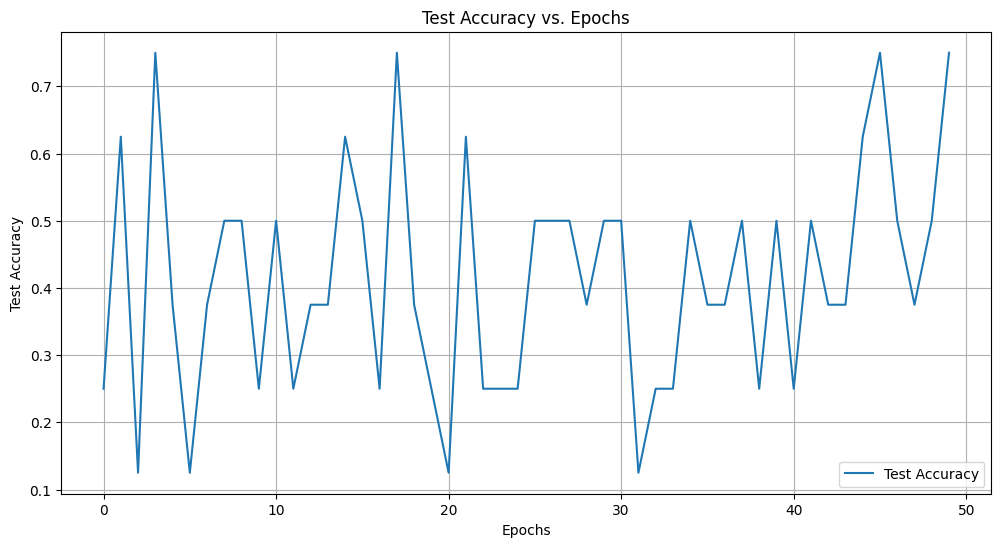

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [21]:
# Построение графика изменения Test accuracy
plt.figure(figsize=(12, 6))
plt.plot(test_accuracy_callback.test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Сохранение графика
plt.savefig('test_accuracy_vs_epochs.png')
files.download('test_accuracy_vs_epochs.png')

In [22]:
# Сохранение модели в формате HDF5
merged_model.save('model_v1.h5')
files.download('model_v1.h5')

# Либо сохранение и скачивание модели в формате TensorFlow SavedModel
merged_model.save('model_v1_saved')
!zip -r model_v1_saved.zip model_v1_saved
files.download('model_v1_saved.zip')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: model_v1_saved/ (stored 0%)
  adding: model_v1_saved/assets/ (stored 0%)
  adding: model_v1_saved/saved_model.pb (deflated 91%)
  adding: model_v1_saved/fingerprint.pb (stored 0%)
  adding: model_v1_saved/variables/ (stored 0%)
  adding: model_v1_saved/variables/variables.index (deflated 79%)
  adding: model_v1_saved/variables/variables.data-00000-of-00001 (deflated 19%)
  adding: model_v1_saved/keras_metadata.pb (deflated 95%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Сохранение модели в формате Keras
merged_model.save('model_v1.keras')


In [25]:
import json

In [26]:
# Сохранение history
with open('history.json', 'w') as f:
    json.dump(history.history, f)

# Загрузка history
with open('history.json', 'r') as f:
    loaded_history = json.load(f)

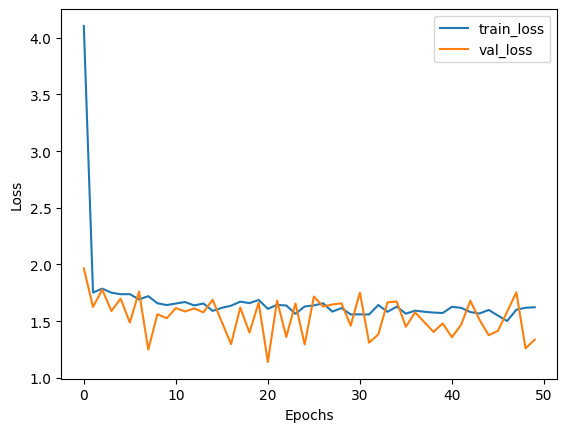

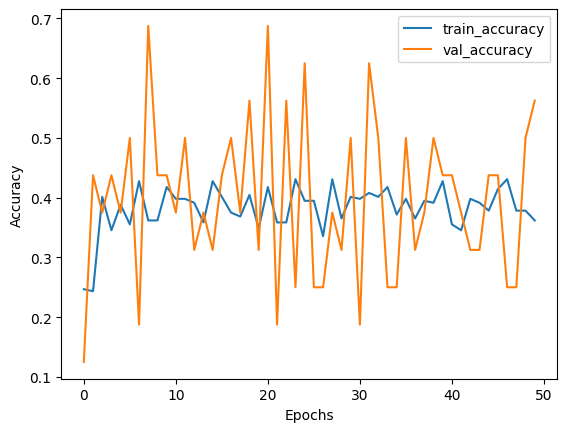

In [27]:
import matplotlib.pyplot as plt

# Построение графиков потерь и точности
def plot_history(history):
    # Потери на обучении и валидации
    plt.plot(history['loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Точность на обучении и валидации
    plt.plot(history['accuracy'], label='train_accuracy')
    plt.plot(history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(loaded_history)
